# All

## Import/read

In [1]:
import os
import pickle
import time
import warnings
from copy import deepcopy
from datetime import datetime
from itertools import repeat
from types import SimpleNamespace
from typing import Callable

import bayes_opt as bayes
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import (
    BayesianOptimization,
    SequentialDomainReductionTransformer,
    UtilityFunction,
)
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from bayes_opt.util import load_logs
from library.classes import Feature, ManageDataSplit, ManageFeatures, feature_objects
from library.classes.trait import DataFrame
from library.feature_func import (
    add_categorical_feature,
    add_numerical_feature,
    f_rolling_mean,
    f_shifted,
    time_arrow,
    add_feature_targets_groupby_stats,
)
from library.utils import read_df, smape, states, states_abb, write_df, build_callbacks
from meteostat import Monthly, Point, Stations
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from traitlets import (
    Any,
    Bool,
    Callable,
    Dict,
    Float,
    HasTraits,
    Int,
    List,
    TraitError,
    TraitType,
    Tuple,
    Unicode,
    default,
    validate,
)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)

In [2]:
# data_path = "../data/"
boundaries_sub_data_path = "other/boundaries"
# bayesian_run_path = "../data/bayesian_runs/"

In [3]:
# df_census = read_df("census_starter.csv")
df_test = read_df("test.csv")
df_train = read_df("train.csv")
df_submission = read_df("sample_submission.csv")
# df_population = read_df('df_population.csv', 'other')
# df_census_population = read_df('df_census_population.csv', 'kaggle_census')
# df_train_census = read_df('df_train_census.csv', 'kaggle_census')
df_adjusted_microbusiness_density = read_df('df_adjusted_microbusiness_density.csv', 'kaggle_census')

# df_boundaries = read_df("us-county-boundaries.csv", boundaries_sub_data_path, delimiter=";")
df_train = pd.merge(df_train, df_adjusted_microbusiness_density, 'left', 'row_id')
df_train = df_train.rename(
    columns={
        "microbusiness_density": "original_microbusiness_density",
        "adjusted_microbusiness_density": "microbusiness_density",
    }
)

### Add census, year, fix dates etc

In [4]:
t = df_train[df_train.isna().any(axis=1)]
if t.shape[0] != 24:
    raise Exception("Nan counts used to be 24... something changed")

In [5]:
df_train[df_train.isna().any(axis=1)].shape

(24, 16)

### Weather save/load

In [6]:
def save_weather_data(path_weather):
    # Temperatures
    temps = df_boundaries[["NAME", "NAMELSAD", "INTPTLAT", "INTPTLON"]].copy()
    temps["min_date"] = df_train["first_day_of_month"].min()
    temps["max_date"] = df_train["first_day_of_month"].max()

    data_list = []
    for idx, row in temps.iterrows():
        p = Point(row["INTPTLAT"], row["INTPTLON"], 70)

        data = Monthly(p, row["min_date"], row["max_date"])
        data = data.fetch()

        if data.shape[0] > 0:
            data["state"] = row["NAME"]
            data["county"] = row["NAMELSAD"]

            data_list.append(data)

        if idx % 100 == 0:
            print(idx)

    weather_data = pd.concat(data_list)
    weather_data.to_csv(path_weather)

In [7]:
path_weather = "../data/other/weather/weather.csv"
# save_weather_data(path_weather)

In [8]:
df_weather = pd.read_csv(path_weather)

## Train

### Feature setup

In [9]:
manage_data_split = ManageDataSplit(df_train)

enabled_tuple = (0, 0.9)
allways_enabled_tuple = (1, 1)
params_tuple = (0, 10)

# Better to clear it. Otherwise it might containt features we do not want
feature_objects.clear()

for cols in [
    {"target_col": "microbusiness_density", "groupby_col": "cfips"},
    {"target_col": "microbusiness_density", "groupby_col": "county"},
    {"target_col": "microbusiness_density", "groupby_col": "state"},
]:
    target_col = cols["target_col"]
    groupby_col = cols["groupby_col"]
    f_col = "{}_{}_rolling_mean".format(groupby_col, target_col)
    feature_target_rolling_mean = Feature(
        f_col,
        f_rolling_mean,
        df_train,
        target_col=target_col,
        groupby_col=groupby_col,
        enabled_bounds=list(repeat(enabled_tuple, 4)),
        params_bounds=list(repeat((1, 10), 4)),
    )


target_col = 'microbusiness_density'
feature_target_shift_mean = Feature(
    f_col='{}_shift'.format(target_col),
    f=f_shifted,
    df=df_train,
    target_col=target_col,
    enabled_bounds=list(repeat(enabled_tuple, 4)),
    params_bounds=list(repeat((1, 10), 4)),
)

for idx, col in enumerate(
    [
        "county",
        "state",
        "cfips",
    ]
):
    _feature = Feature(
        col, add_categorical_feature, df_train, enabled_bounds=[enabled_tuple]
    )

for idx, col in enumerate(
    [
        "median_hh_inc",
        "pct_bb",
        "pct_college",
        "pct_foreign_born",
        "pct_it_workers",
    ]
):
    _feature = Feature(
        col, add_numerical_feature, df_train, enabled_bounds=[enabled_tuple]
    )

feature_time_arrow = Feature(
    "time_arrow", time_arrow, df_train, enabled_bounds=[enabled_tuple]
)

for col in [
    "cfips",
    "state",
    "county",
    "median_hh_inc",
    "pct_bb",
    "pct_college",
    "pct_foreign_born",
    "pct_it_workers",
]:
    for agg_function in ["median", "mean", "std"]:
        f_col = "{}_target_{}".format(col, agg_function)
        _feature = Feature(
            f_col,
            add_feature_targets_groupby_stats,
            df_train,
            col=col,
            agg_function=agg_function,
            enabled_bounds=[enabled_tuple],
            train_idx=manage_data_split._train_idx,
        )

# Bounded region of parameter space
model_pbounds = {
    "num_leaves": (3, 200),
    "num_iterations": (200, 2000),
    "learning_rate": (0.1, 2),
    # "learning_rate": (0.01, 2),
    "bagging_fraction": (0.01, 1),
    "feature_fraction": (0.01, 1),
    "lambda_l1": (0, 100),
    "lambda_l2": (0, 100),
    "bagging_freq": (0, 500),
    "min_data_in_leaf": (10, 3000),
    "min_sum_hessian_in_leaf": (0, 100),
    "max_depth": (-10, 100),
    "path_smooth": (0, 200),
}

In [10]:
objective='mae'
def optimize_this(objective=objective, return_booster=False, **bayes_kwargs):
    
    # Make sure bayes_kwargs are inside the bounds
    # pbounds = manage_features.get_pbound()
    for key, _tuple in pbounds.items():
        params = bayes_kwargs
        if params[key] < _tuple[0]:
            # print(params[key], _tuple)
            params[key] = _tuple[0]
        if params[key] > _tuple[1]:
            # print(params[key], _tuple)
            params[key] = _tuple[1]
            
    # print(params)
    # print(bayes_kwargs)
    
    lgb_train, lgb_eval, lgb_test, model_params = manage_data_split.get_model_input(
        manage_features, df_train, objective=objective, bayes_kwargs=bayes_kwargs
    )

    # callbacks = build_callbacks()
    callbacks = build_callbacks(early_stopping=300)

    model_params = {
        **model_params,
        **{
            "boosting_type": "gbdt",
            # "objective": "mae",
            "objective": objective,
            "metric": "None",
            "first_metric_only": True,
            "num_threads": 6,
            "verbose": -1,
        },
    }
    
    # print(model_params)

    # Can be used to supress warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
    
        gbm = lgb.train(
            model_params,
            lgb_train,
            callbacks=callbacks,
            valid_sets=[lgb_eval],
            feval=smape,
        )
        
        
        pred = gbm.predict(lgb_test.data)
        loss = smape(pred, lgb_test.label)
        
#         print(loss, objective, gbm.best_score)
        if return_booster:
            return (gbm, lgb_train, lgb_eval, lgb_test, model_params)
        else:
            # print(objective, -gbm.best_score["valid_0"]["smape"])
            print(objective, -loss[1], -gbm.best_score["valid_0"]["smape"])
            # return -gbm.best_score["valid_0"]["smape"]
            return -loss[1]

In [11]:
manage_data_split._train_idx.shape

(87780,)

In [12]:
manage_data_split._val_idx.shape

(25080,)

In [13]:
# manage_features = ManageFeatures(feature_objects)
# manage_features.set_model_pbounds(model_pbounds)

# pbounds = manage_features.get_pbounds()


# feature = feature_target_shift_mean
# df_mapped = manage_features._make_mapped(d)
# df_mapped_feature = df_mapped[df_mapped["f_col"] == feature.f_col]
# r = feature.f(
#     df=feature.df.copy(),
#     df_mapped_feature=df_mapped_feature,
#     f_col=feature.f_col,
#     **feature._kwargs
# )

#### Start bayesian optimization

In [ ]:
manage_features = ManageFeatures(feature_objects)
manage_features.set_model_pbounds(model_pbounds)

pbounds = manage_features.get_pbounds()

acquisition_function = UtilityFunction(kind="ucb")
# acquisition_function = UtilityFunction(kind="ucb", kappa=0.1)
# acquisition_function = UtilityFunction(kind="ucb", kappa=1)
# bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)
optimizer = BayesianOptimization(
    f=optimize_this,
    pbounds=pbounds,
    verbose=0,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=5,
    # bounds_transformer=bounds_transformer
)

# optimizer.set_gp_params(alpha=1e-2, n_restarts_optimizer=10)

# load_logs(optimizer, logs=["../data/bayesian_optimizer/2023-03-02_12-17-19_logs.json"]);

dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

logger = JSONLogger(path="../data/bayesian_optimizer/{}_logs.json".format(dt))
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

objective='mae'
optimizer.maximize(
    init_points=100,
    n_iter=2000,
    # acquisition_function=acquisition_function
)

print(optimizer.max['target'])

mae -13.759008258591177 -13.54933906914685
mae -4.949644811751226 -4.406839431097491
mae -9.568030899170665 -8.894588702743519
mae -3.213491122215038 -3.370482334414001
mae -9.835615166311596 -8.723275521641765
mae -12.919028510150646 -9.244148678795463
mae -26.72257393340949 -25.372063140151994
mae -8.411520431536166 -9.082727838333998
mae -5.28544280491872 -5.283675847672556
mae -7.439158689796446 -7.00945242494947
mae -52.91051588325632 -47.08116505512672
mae -13.578078233052834 -12.497561856057958
mae -9.294273805653251 -7.423753103367469
mae -50.21356545033679 -41.81608199330232
mae -4.8353080146918135 -4.894969578596388
mae -48.063312299744624 -73.78024816954341
mae -4.537000517170645 -4.190124793311292
mae -5.520372937257331 -4.574354030042025
mae -4.647611262521861 -4.672945979302349
mae -13.896572833485164 -9.527166267072145
mae -37.35508530823486 -24.803300884167534
mae -13.471884519492823 -10.30899737205935
mae -3.931593677242981 -4.237919266338115
mae -5.161197718120733 -4.

In [15]:
print(optimizer.max['target'])

-1.7441399873500656


In [16]:
df_optimizer_params = pd.DataFrame([x['params'] for x in optimizer.res])
df_optimizer_target = pd.DataFrame([x['target'] for x in optimizer.res], columns=['target'])

df_optimizer = pd.concat([df_optimizer_target, df_optimizer_params], axis=1)

<Axes: >

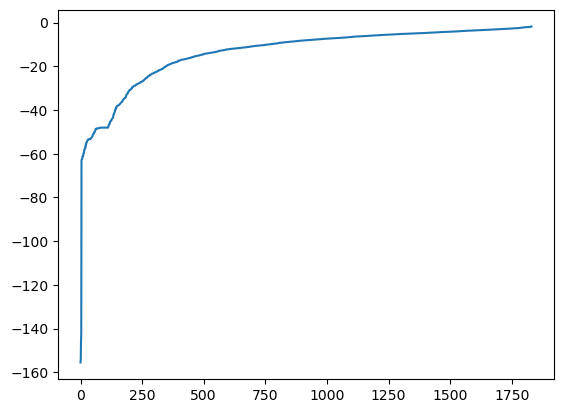

In [26]:
df_optimizer['target'].sort_values().reset_index(drop=True).plot()

#### SHAPE

In [28]:
manage_features = ManageFeatures(feature_objects)
manage_features.set_model_pbounds(model_pbounds)

pbounds = manage_features.get_pbounds()

# acquisition_function = UtilityFunction(kind="ucb", kappa=0.1)
# acquisition_function = UtilityFunction(kind="ucb", kappa=1)
# bounds_transformer = SequentialDomainReductionTransformer(minimum_window=0.5)
optimizer = BayesianOptimization(
    f=optimize_this,
    pbounds=pbounds,
    verbose=0,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=5,
    # bounds_transformer=bounds_transformer
)

# optimizer.set_gp_params(alpha=1e-2, n_restarts_optimizer=10)

load_logs(optimizer, logs=['../data/bayesian_optimizer/2023-03-03_04-06-56_logs.json']);

# dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# logger = JSONLogger(path="../data/bayesian_optimizer/{}_logs.json".format(dt))
# optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

# objective='mae'
# optimizer.maximize(
#     init_points=100,
#     n_iter=2000,
#     # acquisition_function=acquisition_function
# )

print(optimizer.max['target'])

-1.7441399873500656


In [31]:
gbm, lgb_train, lgb_eval, lgb_test, model_params = optimize_this(
    "mae", return_booster=True, **optimizer.max["params"]
)

In [34]:
gbm.save_model('../data/lgb/gbm')

lgb_train_path = '../data/lgb/lgb_train'
lgb_eval_path = '../data/lgb/lgb_eval'
lgb_test_path = '../data/lgb/lgb_test'

os.remove(lgb_train_path)
os.remove(lgb_eval_path)
os.remove(lgb_test_path)

lgb_train.save_binary(lgb_train_path)
lgb_eval.save_binary(lgb_eval_path)
lgb_test.save_binary(lgb_test_path)

lgb_train.data.to_csv('../data/lgb/lgb_train_data')
lgb_eval.data.to_csv('../data/lgb/lgb_eval_data')
lgb_test.data.to_csv('../data/lgb/lgb_test_data')

with open('../data/lgb/model_params', 'wb') as handle:
    pickle.dump(model_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../data/lgb/bayes_params', 'wb') as handle:
    pickle.dump(optimizer.max["params"], handle, protocol=pickle.HIGHEST_PROTOCOL)

[LightGBM] [Info] Saving data to binary file ../data/lgb/lgb_train
[LightGBM] [Info] Saving data to binary file ../data/lgb/lgb_eval
[LightGBM] [Info] Saving data to binary file ../data/lgb/lgb_test


In [52]:
# with open('../data/lgb/lgb_train.pickle', 'wb') as handle:
#     pickle.dump(lgb_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [49]:
l.get_data()

'../data/lgb/lgb_test'

In [59]:
l = lgb.Dataset(data='../data/lgb/lgb_test').construct()
l.data = pd.read_csv('../data/lgb/lgb_train_data')
# l = l.construct()

[LightGBM] [Info] Load from binary file ../data/lgb/lgb_test


In [60]:
l.label

array([3.2742248, 3.2922273, 3.3124802, ..., 1.8185124, 1.8185124,
       1.8366976], dtype=float32)

In [61]:
l.data

,row_id,params_cfips_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_0,params_microbusiness_density_shift_0,params_microbusiness_density_shift_2,median_hh_inc,cfips_target_std,state_target_median,state_target_std,county_target_median,county_target_std,median_hh_inc_target_mean,median_hh_inc_target_std,pct_bb_target_median,pct_bb_target_mean,pct_college_target_median,pct_it_workers_target_median
0,1001_2020-04-01,2.761150,1.230563,2.695891,2.695891,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
1,1001_2020-05-01,2.824160,1.213830,2.855664,2.855664,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
2,1001_2020-06-01,2.828660,1.215760,2.797156,2.797156,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
3,1001_2020-07-01,2.842162,1.212542,2.797156,2.797156,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
4,1001_2020-08-01,2.902921,1.206750,2.794905,2.794905,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63949,56045_2021-07-01,1.673031,0.341797,1.600291,1.600291,57031.0,0.069152,3.650267,12.688738,1.618476,0.069152,1.711055,0.049772,3.210863,4.165405,3.105747,1.734012
63950,56045_2021-08-01,1.673031,0.334821,1.618476,1.618476,57031.0,0.069152,3.650267,12.688738,1.618476,0.069152,1.711055,0.049772,3.210863,4.165405,3.105747,1.734012
63951,56045_2021-09-01,1.691217,0.334821,1.745772,1.745772,57031.0,0.069152,3.650267,12.688738,1.618476,0.069152,1.711055,0.049772,3.210863,4.165405,3.105747,1.734012
63952,56045_2021-10-01,1.709402,0.327846,1.782142,1.782142,57031.0,0.069152,3.650267,12.688738,1.618476,0.069152,1.711055,0.049772,3.210863,4.165405,3.105747,1.734012


#### Stuff

In [28]:
lgb_train.data

,params_cfips_microbusiness_density_rolling_mean_1,params_county_microbusiness_density_rolling_mean_0,params_microbusiness_density_shift_0,params_microbusiness_density_shift_2,median_hh_inc,cfips_target_std,state_target_median,state_target_std,county_target_median,county_target_std,median_hh_inc_target_mean,median_hh_inc_target_std,pct_bb_target_median,pct_bb_target_mean,pct_college_target_median,pct_it_workers_target_median
row_id,,,,,,,,,,,,,,,,
1001_2020-04-01,2.761150,1.230563,2.695891,2.695891,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
1001_2020-05-01,2.824160,1.213830,2.855664,2.855664,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
1001_2020-06-01,2.828660,1.215760,2.797156,2.797156,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
1001_2020-07-01,2.842162,1.212542,2.797156,2.797156,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
1001_2020-08-01,2.902921,1.206750,2.794905,2.794905,58786.0,0.118331,1.579628,1.485095,2.881543,0.118331,2.865978,0.093743,3.055225,4.791481,3.128786,2.404352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045_2021-07-01,1.673031,0.341797,1.600291,1.600291,57031.0,0.069152,3.650267,12.688738,1.618476,0.069152,1.711055,0.049772,3.210863,4.165405,3.105747,1.734012
56045_2021-08-01,1.673031,0.334821,1.618476,1.618476,57031.0,0.069152,3.650267,12.688738,1.618476,0.069152,1.711055,0.049772,3.210863,4.165405,3.105747,1.734012
56045_2021-09-01,1.691217,0.334821,1.745772,1.745772,57031.0,0.069152,3.650267,12.688738,1.618476,0.069152,1.711055,0.049772,3.210863,4.165405,3.105747,1.734012


In [ ]:
# def remove_outliers(df, f_col, train_idx):
#     """
#     Remove outlies. Should be run on train only
#     """
#     max_density = (
#         train.groupby("cfips")["microbusiness_density"]
#         .mean()
#         .rename("max_microbusiness_density")
#         .reset_index()
#     )
#     max_density["max_microbusiness_density"] = (
#         max_density["max_microbusiness_density"] * outlier_multiplier
#     )
#     t1 = pd.merge(
#         train.reset_index(), max_density, "left", left_on="cfips", right_on="cfips"
#     )

#     idx = t1[t1["microbusiness_density"] < t1["max_microbusiness_density"]]["index"]
#     t = train.loc[idx].copy()

#     return t

In [79]:
optimizer.max['params']

{'bagging_fraction': 0.4984809013777921,
 'bagging_freq': 291.7498718600283,
 'enabled_cfips_': 0.8453694167683664,
 'enabled_cfips_microbusiness_density_rolling_mean_0': 0.8491860738142917,
 'enabled_cfips_microbusiness_density_rolling_mean_1': 0.10052318446521429,
 'enabled_cfips_microbusiness_density_rolling_mean_2': 0.7591994694992014,
 'enabled_cfips_microbusiness_density_rolling_mean_3': 0.31142533658035715,
 'enabled_cfips_target_mean_': 0.09074454557638063,
 'enabled_cfips_target_median_': 0.3450681594604037,
 'enabled_cfips_target_std_': 0.45931931760532313,
 'enabled_county_': 0.8649927737686168,
 'enabled_county_microbusiness_density_rolling_mean_0': 0.33436135379520654,
 'enabled_county_microbusiness_density_rolling_mean_1': 0.011132470440321885,
 'enabled_county_microbusiness_density_rolling_mean_2': 0.7737361982893723,
 'enabled_county_microbusiness_density_rolling_mean_3': 0.09999967458632873,
 'enabled_county_target_mean_': 0.4305051395881065,
 'enabled_county_target_me

In [ ]:
optimizer.max['params']

In [ ]:
df_optimizer = pd.DataFrame([x['target'] for x in optimizer.res])
df_optimizer[df_optimizer[0] > -5].plot()

In [ ]:
df_optimizer_params = pd.DataFrame([x['params'] for x in optimizer.res])
df_optimizer_target = pd.DataFrame([x['target'] for x in optimizer.res], columns=['target'])

df_optimizer = pd.concat([df_optimizer_target, df_optimizer_params], axis=1)

In [ ]:
df_optimizer.sort_values('target').tail(10)

In [ ]:
df_optimizer.sort_values('target').tail(50)

In [ ]:
for label, content in df_optimizer.iteritems():
    ax = content.plot(title=label)
    plt.show()
    # break

In [ ]:
gbm, lgb_train, lgb_eval, lgb_test = optimize_this(return_booster=True, **optimizer.max['params'])

In [ ]:
lgb_train.data.columns

In [ ]:
print(gbm.best_score["valid_0"]["smape"])

pred = gbm.predict(lgb_test.data)
loss = smape(pred, lgb_test.label)
print('test loss', loss)

In [ ]:
# params = optimizer.max['params']
# print(optimizer.max['target'])
# # params['num_iterations'] = 1000

# lgb_train, lgb_eval, lgb_test, model_params = manage_data_split.get_model_input(
#     manage_features, df_train, objective=objective, bayes_kwargs=params
# )

# recorded_evaluations = {}
# # callbacks = build_callbacks(log_evaluation=100, record_evaluation=recorded_evaluations)
# callbacks = build_callbacks(early_stopping=300, log_evaluation=100, record_evaluation=recorded_evaluations)

# model_params = {
#     **model_params,
#     **{
#         "boosting_type": "gbdt",
#         "objective": objective,
#         "metric": "None",
#         "first_metric_only": True,
#         "num_threads": 6,
#         "verbose": -1,
#     },
# }

# gbm = lgb.train(
#     model_params,
#     lgb_train,
#     callbacks=callbacks,
#     valid_sets=[lgb_eval],
#     feval=smape,
# )
# # gbm.best_score
# gbm.best_score["valid_0"]["smape"]

# pred = gbm.predict(lgb_test.data)
# loss = smape(pred, lgb_test.label)
# print('test loss', loss)

In [ ]:
optimizer.max

In [ ]:
gbm.best_iteration

In [ ]:
np.array(recorded_evaluations['valid_0']['smape']).min()

In [ ]:
np.array(recorded_evaluations['valid_1']['smape']).min()

In [ ]:
lgb.__version__

In [ ]:
gbm.best_score

In [ ]:
gbm.best_iteration

In [ ]:
model_params

In [ ]:
gbm.best_score["valid_0"]["smape"]

In [ ]:
recorded_evaluations['valid_0']['smape']

In [ ]:
lgb_train.data.shape

In [ ]:
lgb_train.data.head(3)

In [ ]:
len([1 for x in range(lgb_train.data.shape[1])])

In [ ]:
lgb_train.data.shape

In [ ]:
lgb_train.weight = [1 for x in range(lgb_train.data.shape[0])]

####  Find biggest errors

In [ ]:
params

In [ ]:
lgb_train.label

In [ ]:
lgb_train.data

In [ ]:
gbm.best_score["valid_2"]["smape"]

In [ ]:
params

In [ ]:
lgb.plot_importance(gbm, ignore_zero=False)
plt.show()
lgb.plot_importance(gbm, importance_type='gain', ignore_zero=False)

In [ ]:
import PIL.Image as Image
import io
ax = lgb.create_tree_digraph(gbm, show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count', 'data_percentage'])
b = ax._repr_image_png()
image = Image.open(io.BytesIO(b))
image.save('tree.png')

In [ ]:
df_features = manage_features.generate_features(params)
df_target = manage_features.generate_target(df_train)

In [ ]:
data = lgb_test.data.copy()
data['label'] = lgb_test.label.copy()
data['pred'] = gbm.predict(lgb_test.data)

In [ ]:
def smape(pred, eval_data):
    if hasattr(eval_data, "label"):
        A = eval_data.label  # Used by lightgbm
    else:
        A = eval_data  # Used by numpy
    F = pred

    if type(pred) == int or type(pred) == float:
        # Single cases
        value = 100 / 1 * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    else:
        print(type(pred), pred)
        # Many cases
        value = 100 / len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return "smape", value, False

In [ ]:
data['smape'] = data.apply(lambda row: smape(float(row['pred']), row['label'])[1], axis=1)

In [ ]:
data

In [ ]:
data.sort_values('smape')[:-2]['smape'].mean()

In [ ]:
data.sort_values('smape').tail(50)

In [ ]:
data[data['pred'] < 0.02]

In [ ]:
# cfips_avg_error = data.groupby('cfips')['smape'].mean().sort_values()

In [ ]:
# cfips_avg_error[:-50].mean()

In [ ]:
# t1 = data[data['cfips'].isin(cfips_avg_error[-50:].index)].copy()
# print('current:', t1['smape'].mean())
# t1['pred'] = t1['pred'] * 1.03
# t1['smape'] = t1.apply(lambda row: smape(row['pred'], row['label'])[1], axis=1)
# print('adjusted:', t1['smape'].mean())

In [ ]:
t1.sort_values('smape')

In [ ]:
df_train[df_train['cfips'] == 12001]

In [ ]:
data.groupby('cfips')['smape'].mean().mean()

In [ ]:
data[data['cfips'] == 28055]

In [ ]:
data

In [ ]:
smape(data['pred'].values, lgb_test.label)

In [ ]:
df_train.head(50)

In [ ]:
t0 = df_features[df_features.isna().any(axis=1)]
t0

In [ ]:
lgb_train.label

In [ ]:
pd.merge(df_target.rename('shifted_target'), df_train.set_index('row_id'), 'left', left_index=True, right_index=True)

In [ ]:
t0 = lgb_test.data
t0[t0.isna().any(axis=1)]

In [ ]:
df_train[df_train['row_id'].isin(lgb_test.data.index)]

# Analyze

## Adjust target by population

In [ ]:
t2 = pd.merge(df_train, df_target_population, "left", "row_id")
# t2 = pd.merge(t2, df_train_census, "left", "row_id")

# t2["calc_active"] = (
#     (t2["census_over_18_population_x1000"] * t2["microbusiness_density"] * 10)
#     .apply(np.round)
#     .astype(int)
# )

In [ ]:
t2[t2['cfips'] == 1001]['active'].value_counts()

In [ ]:
t2[(t2['cfips'] == 1001) & (t2['active'] == 1243)]

In [ ]:
t2

In [ ]:
df_train_census

In [ ]:
t3 = 1 - (t2['population_x1000'] / t2['census_population_x1000'])
t3.hist(bins=40)

In [ ]:
t3 = 1 - (t2['census_over_18_population_x1000'] / t2['census_population_x1000'])
t3.hist(bins=40, log=True)

In [ ]:
t2.groupby(['state', 'county'])['census_over_18_population_x1000'].std().sort_values()

In [ ]:
t2[(t2['state'] == 'Arizona') & (t2['county'] == 'Maricopa County')][['first_day_of_month', 'microbusiness_density', 'active', 'census_over_18_population_x1000']]

In [ ]:
df_test

### Per state target data

In [ ]:
train_dates, eval_dates = split_dates(df_train)

In [ ]:
ma

In [ ]:
train_data = df_train[df_train["first_day_of_month"].isin(train_dates)]
eval_data = df_train[df_train["first_day_of_month"].isin(eval_dates)]

In [ ]:
manage_data_split = ManageDataSplit(df_train)
train_data = manage_data_split.get_train_data()

In [ ]:
# def add_feature_targets_groupby_stats(
#     df,
#     col_group,
#     new_col_template="{}_target_{}",
#     agg_functions=["mean", "std", "median"],
# ):
#     t0 = df.groupby(col_group)["microbusiness_density"].agg(agg_functions)
#     t0.columns = [new_col_template.format(col_group, x) for x in t0.columns]

#     df = pd.merge(df, t0, "left", left_on=col_group, right_index=True)

#     return df

In [ ]:
def add_feature_targets_groupby_stats(
    df,
    f_col,
    # new_col_template="{}_target_{}",
    agg_function=None,
    # agg_functions=["mean", "std", "median"],
    train_idx=None,
    col=None,
    **kwargs
):
    df = df.copy()
    t0 = df.groupby(col)["microbusiness_density"].agg(agg_function)
    t0 = t0.rename(f_col)

    df = pd.merge(df, t0, "left", left_on=col, right_index=True).set_index('row_id')
    return pd.DataFrame(df[f_col])

In [ ]:
add_feature_targets_groupby_stats(df_train, 'ttttt', agg_function='mean', col='state')

In [ ]:
add_feature_targets_groupby_stats(train_data, "state")